**What I want to do:** Determine if there is causal relation between prices of different coins using Granger Causality and benefit.

## 01 Admin and Imports

In [1]:
# the usual suspects...
import os, sys
from datetime import datetime
import numpy as np
import pandas as pd
import itertools

In [2]:
# this is for my bitcoin prices
import quandl

# visualisation libraries: I'll go ahead and use plotly (offline) for graphing because its d3 
# and so I can track prices over time
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as sct
import seaborn as sns
sns.set()
sns.set(style="ticks")
sns.set_color_codes("muted")

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
pd.set_option('display.float_format', lambda x:'%.10f' %x)
import glob

# we'll need this for plotting in nice colours. Trust me on this.
COLOR_PALETTE = [    
               "#348ABD",
               "#A60628",
               "#7A68A6",
               "#467821",
               "#CF4457",
               "#188487",
               "#E24A33"
              ]

## 02 Source data

In [31]:
bool_i_prefer_to_work_offline=True
if len(glob.glob('*.pickle'))>0:
    if int(datetime.today().strftime('%Y%m%d')) >= int(glob.glob('*.pickle')[-1].split('.')[0].split('_')[-1]):
        bool_i_prefer_to_work_offline = False
    date_of_latest_available_data=glob.glob('*.pickle')[-1].split('.')[0].split('_')[-1]
date_of_latest_available_data

'20171226'

In [32]:
bool_i_prefer_to_work_offline

False

In [4]:
df_combined = pd.read_pickle('btc_altcoin_cleansed_'+date_of_latest_available_data+'.pickle')

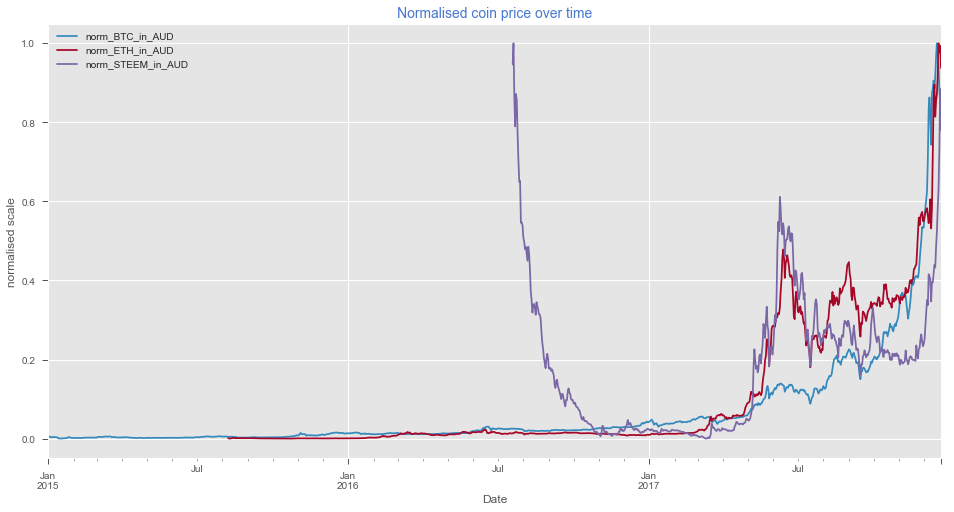

In [5]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,8));ax = fig.add_subplot(111)
iter_colour = itertools.cycle(COLOR_PALETTE)
# for cols in ['norm_'+col for col in cols_to_normalise]:
for cols in ['norm_BTC_in_AUD','norm_ETH_in_AUD','norm_STEEM_in_AUD']:
    df_combined[cols].plot(color=next(iter_colour))
plt.title('Normalised coin price over time', color='B',size=14);
plt.legend(loc='best');plt.ylabel('normalised scale');plt.xlabel('Date');plt.show()

## 03 Lets fix Steem

Something happened to Steem initially which caused its price to drop like crazy. There's theory about how some hacker drained $85000 dollars suddenly or that it is inherently deflationary. At the moment, I dont want to think too much about it. Will simply work around this by removing any traces before March 2017.

In [6]:
cols_to_cleanse = ['norm_STEEM_in_AUD','norm_BTC_in_AUD','norm_ETH_in_AUD','norm_OMG_in_AUD']
# for cols in cols_to_cleanse:
#     df_combined[cols] = np.where(df_combined.index<'2017-03-01',np.nan,df_combined[cols])

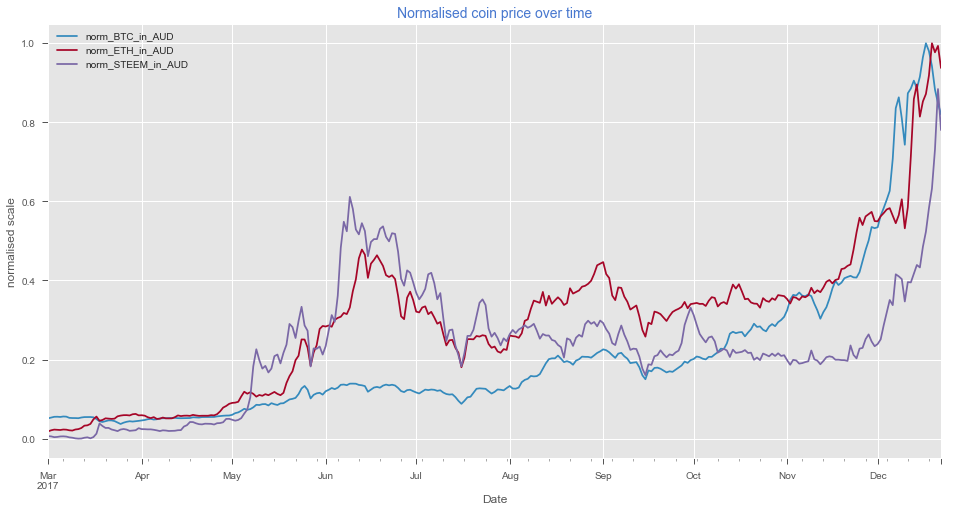

In [7]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,8));ax = fig.add_subplot(111)
iter_colour = itertools.cycle(COLOR_PALETTE)
# for cols in ['norm_'+col for col in cols_to_normalise]:
for cols in ['norm_BTC_in_AUD','norm_ETH_in_AUD','norm_STEEM_in_AUD']:
    df_combined[df_combined.index>='2017-03-01'][cols].plot(color=next(iter_colour))
plt.title('Normalised coin price over time', color='B',size=14);
plt.legend(loc='best');plt.ylabel('normalised scale');plt.xlabel('Date');plt.show()

## Fix stationarity

These plots tell me that the data is likely not stationary.  Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.
— Page 215, Forecasting: principles and practice

[This link](http://www.statisticshowto.com/stationarity/) explains why stationarity is important.

In [8]:
df_granger = df_combined.loc[df_combined.index>='2017-03-01',['BTC_in_AUD','ETH_in_AUD','STEEM_in_AUD',
    'norm_BTC_in_AUD','norm_ETH_in_AUD','norm_STEEM_in_AUD']]

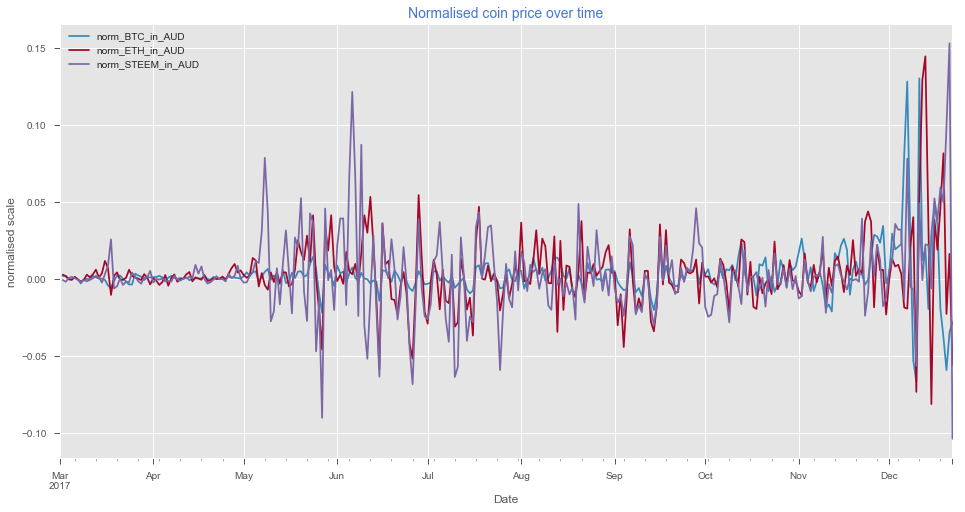

In [9]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,8));ax = fig.add_subplot(111)
iter_colour = itertools.cycle(COLOR_PALETTE)
# for cols in ['norm_'+col for col in cols_to_normalise]:
for cols in ['norm_BTC_in_AUD','norm_ETH_in_AUD','norm_STEEM_in_AUD']:
# for cols in ['BTC_in_AUD','ETH_in_AUD','STEEM_in_AUD']:
    df_granger.diff()[cols].plot(color=next(iter_colour))
plt.title('Normalised coin price over time', color='B',size=14);
plt.legend(loc='best');plt.ylabel('normalised scale');plt.xlabel('Date');plt.show()

Lets take a look at the past 2 months. Notice how Ether tracks BTC inversely, while STEEM seems to follow Ether. Something caused everyone to explode in December, and this has stressed the trend.

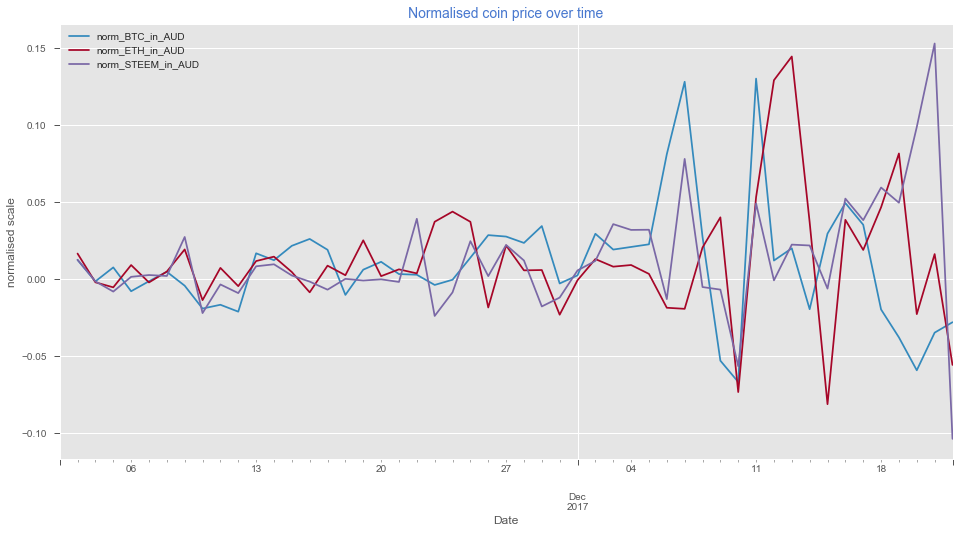

In [10]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,8));ax = fig.add_subplot(111)
iter_colour = itertools.cycle(COLOR_PALETTE)
# for cols in ['norm_'+col for col in cols_to_normalise]:
for cols in ['norm_BTC_in_AUD','norm_ETH_in_AUD','norm_STEEM_in_AUD']:
# for cols in ['BTC_in_AUD','ETH_in_AUD','STEEM_in_AUD']:
    df_granger[df_granger.index>'2017-11-01'].diff()[cols].plot(color=next(iter_colour))
plt.title('Normalised coin price over time', color='B',size=14);
plt.legend(loc='best');plt.ylabel('normalised scale');plt.xlabel('Date');plt.show()

The info is all over the place. so lets look to statistical analyses to get a better sense.

## Granger causality

https://stats.stackexchange.com/questions/291474/causal-inference-with-counterfactuals-and-a-b-tests

Instead of "paying for" an A/B test for all hypothesis' (designing an experiment, running it under controlled situation etc), a statistical analysis can be conducted on past data as a "first pass" on a hypothesis. If it shows there is evidence of the hypothesis being true, the A/B test can be designed, and if not you don't need to waste your money. Nobody designs an A/B test out of thin air. Having said that, to draw anything more than "educated guesses", you have to accept that the baseline bias across the past data is zero as well as that the differential treatment effect bias is zero too. These are very demanding assumptions for an observational study. You could put all your eggs on the propensity-score basket and hope for the best but I would advise it. 

Given two sets of time series data, x and y, granger-causality is a method which attempts to determine whether one series is likely to influence change in the other. This is accomplished by taking different lags of one series and using that to model the change in the second series. We are then trying to determine whether we can say that statistically x provides more information about future values of y than past values of y alone. Under this definition it is clear that we are not trying to prove actual causation, only that the two values are related by some phenomenon.

Granger and ARIMA work when your data is stationary.

In [11]:
df_granger.head()

,BTC_in_AUD,ETH_in_AUD,STEEM_in_AUD,norm_BTC_in_AUD,norm_ETH_in_AUD,norm_STEEM_in_AUD
Date,,,,,,
2017-03-01,1587.9140361700,21.1918243525,0.1349250557,0.0514013906,0.0184360965,0.0063599391
2017-03-02,1636.2089320900,24.1954886695,0.1308803525,0.0532575221,0.0211294615,0.0056417805
2017-03-03,1686.4600657100,26.1374158178,0.1201096859,0.0551888383,0.0228707740,0.0037293914
2017-03-04,1691.7615390000,25.6912599074,0.1233294162,0.0553925913,0.0224707091,0.0043010716
2017-03-05,1676.8484517700,24.9714762274,0.1302911247,0.0548194324,0.0218252841,0.0055371600


In [12]:
from statsmodels.tsa.stattools import grangercausalitytests

/Users/Vivek/anaconda/envs/cryptoMe/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



One common way to choose the lags in granger causality is to pick several values and run the Granger test several times to see if the results are the same for different lag levels. The results should not be sensitive to lags.

In [18]:
granger_test_result = grangercausalitytests(df_granger[['norm_BTC_in_AUD','norm_ETH_in_AUD']], 
                                            maxlag=12, verbose=True)
granger_test_result

optimal_lag = -1; F_test = -1.0;

for key in granger_test_result.keys():
    _F_test_ = granger_test_result[key][0]['params_ftest'][0]
    _p_val = granger_test_result[key][0]['params_ftest'][1]
    if (_F_test_ > F_test) & (_p_val<=0.05):
        F_test = _F_test_
        optimal_lag = key
print ("\n")
print ("Optimal LAG: {} & F_test: {}".format(optimal_lag, F_test))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4151  , p=0.0656  , df_denom=293, df_num=1
ssr based chi2 test:   chi2=3.4501  , p=0.0632  , df=1
likelihood ratio test: chi2=3.4301  , p=0.0640  , df=1
parameter F test:         F=3.4151  , p=0.0656  , df_denom=293, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.9186 , p=0.0000  , df_denom=290, df_num=2
ssr based chi2 test:   chi2=32.3861 , p=0.0000  , df=2
likelihood ratio test: chi2=30.7286 , p=0.0000  , df=2
parameter F test:         F=15.9186 , p=0.0000  , df_denom=290, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=13.1145 , p=0.0000  , df_denom=287, df_num=3
ssr based chi2 test:   chi2=40.3032 , p=0.0000  , df=3
likelihood ratio test: chi2=37.7698 , p=0.0000  , df=3
parameter F test:         F=13.1145 , p=0.0000  , df_denom=287, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.8118 , p=0.0000  

What does this mean? : 
Look at the tuple in the result element - the first element a dictionary with teststatistic, pvalues, degrees of freedom.

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test. 

The null hypothesis for all four test is that the coefficients corresponding to past values of the second time series are zero. The fact that the p-value << 0.05 indicates that there is 'likely' some 'Granger Causality' between the two time series for a given load

Also, the ssr-based F test is the "standard" granger causality test. There's a decent google group created by the author of granger causality where he says how test 1 and 4 are pretty much the same. https://groups.google.com/forum/#!topic/pystatsmodels/4jPEvJsRltQ



## Formalise into function

In [19]:
def granger_causality(df, token1,token2):
    granger_test_result = grangercausalitytests(df[[token1,token2]].dropna(how='any'), 
                                                maxlag=10, verbose=False)

    optimal_lag = -1; F_test = -1.0; 

    for key in granger_test_result.keys():
        _F_test_ = granger_test_result[key][0]['params_ftest'][0]
        _p_val = granger_test_result[key][0]['params_ftest'][1]
        if (_F_test_ > F_test) & (_p_val<=0.05):
            F_test = _F_test_
            optimal_lag = key
    
    token1
    
    return {'token1':[token1.split('_')[1]], 
            'token2':[token2.split('_')[1]],'optimal_lag':[optimal_lag], 'F_test':[F_test]}

In [20]:
granger_causality(df_granger, token1='norm_BTC_in_AUD',token2='norm_ETH_in_AUD')

{'F_test': [15.918576825810998],
 'optimal_lag': [2],
 'token1': ['BTC'],
 'token2': ['ETH']}

In [21]:
granger_causality(df_granger, token1='norm_ETH_in_AUD',token2='norm_BTC_in_AUD')

{'F_test': [23.736384870989518],
 'optimal_lag': [1],
 'token1': ['ETH'],
 'token2': ['BTC']}

In [22]:
pd.DataFrame(granger_causality(df_granger, token1='norm_ETH_in_AUD',token2='norm_BTC_in_AUD'))

,F_test,optimal_lag,token1,token2
0,23.7363848710,1,ETH,BTC


## Pipeline the shit out of this

In [23]:
def granger_pipeline():
    normalised_cols = [cols for cols in df_combined.columns.tolist() if 'norm_' in cols]
    df = df_combined.loc[df_combined.index>='2017-03-01',normalised_cols]
    df_granger_linked = pd.DataFrame()
    unsuccessful_tokens = []
    for col1 in normalised_cols:
        for col2 in normalised_cols:
            if col1!=col2:
                try:
                    df_granger_linked = pd.concat([df_granger_linked,
                                                pd.DataFrame(granger_causality(df,col1,col2))],
                                                 ignore_index=True)
                except:
                    unsuccessful_tokens.append([col1,col2])
    return df_granger_linked, unsuccessful_tokens

In [24]:
df_granger_linked, unsuccessful_tokens = granger_pipeline()
df_granger_linked.head(5)

,F_test,optimal_lag,token1,token2
0,15.0092298976,1,BTC,ARDR
1,5.0937383269,1,BTC,BCN
2,27.5765445075,2,BTC,DASH
3,6.3380755300,1,BTC,DGB
4,15.9185768258,2,BTC,ETH


In [25]:
unsuccessful_tokens

[]

The -1 is a result of all lags failing the p-value test.

## Sense checking the inference test results

Lets look at one coin (say DASH).

In [26]:
df_granger_linked[(df_granger_linked.token1.str.contains('BTC|LTC')) & 
                  (df_granger_linked.token2.str.contains('BTC|LTC'))]

,F_test,optimal_lag,token1,token2
5,36.8471190597,1,BTC,LTC
66,42.2319726605,1,LTC,BTC


This is quite pronounced in LTC where I've checked charts for BTC and LTC against USD.

In [27]:
df_granger_linked[(df_granger_linked.token1.str.contains('BTC|STR')) & 
                  (df_granger_linked.token2.str.contains('BTC|STR'))]

,F_test,optimal_lag,token1,token2
8,17.8974871809,4,BTC,STR
99,14.9179669617,1,STR,BTC


In [28]:
df_granger_linked[(df_granger_linked.token1.str.contains('BTC|XEM')) & 
                  (df_granger_linked.token2.str.contains('BTC|XEM'))]

,F_test,optimal_lag,token1,token2
10,35.2535832941,2,BTC,XEM
121,30.7736129019,1,XEM,BTC


## Storing results into csv

In [30]:
if bool_i_prefer_to_work_offline==False:
    df_granger_linked.to_csv('granger_causality_tokens_'+date_of_latest_available_data+'.csv')

## Understand the results

In [34]:
df_granger_linked.sort_values(by=['F_test','token2'], ascending=[False,True]).head(10)

,F_test,optimal_lag,token1,token2
130,65.2781378449,3,XEM,STR
116,57.4801599006,1,XRP,LTC
111,47.6784676057,1,XRP,ARDR
66,42.2319726605,1,LTC,BTC
11,37.9899417947,6,ARDR,BTC
5,36.8471190597,1,BTC,LTC
31,35.7795576790,1,BCN,XRP
10,35.2535832941,2,BTC,XEM
96,32.7706196892,1,STEEM,STR
50,32.4933121944,1,DGB,OMG


Need to get folks with subject matter knowledge to tweak these things. I suspect the large time frame causes heaps of spurious results.